# Линейная регрессия
__Суммарное количество баллов: 10__

__Решение отправлять на `ml.course.practice@gmail.com`__

__Тема письма: `[HSE][MS][ML][HW03] <ФИ>`, где вместо `<ФИ>` указаны фамилия и имя__

In [1]:
from sklearn.datasets import make_blobs, make_moons
from sklearn.model_selection import train_test_split
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib
import copy

In [2]:
def read_data(path="boston.csv"):
    dataframe = np.genfromtxt(path, delimiter=",", skip_header=15)
    np.random.seed(42)
    np.random.shuffle(dataframe)
    X = dataframe[:, :-1]
    y = dataframe[:, -1]
    return X, y

In [3]:
def generate_synthetic(size:int, dim=6, noise=0.1):
    X = np.random.randn(size, dim)
    w = np.random.randn(dim + 1)
    noise = noise * np.random.randn(size)
    y = X.dot(w[1:]) + w[0] + noise
    return X, y

### Задание 1 (1 балл)
Для начала нужно понять, какую метрику для ошибки будем использовать. В нашем случае нам подойдет стандартная метрика MSE. Также чтобы оценить качество модели нам понадобится метрика $R^2$. Реализуйте обе эти метрики.

In [4]:
def mse(y_true:np.ndarray, y_predicted:np.ndarray):
    return ((y_predicted - y_true)**2).mean()

def r2(y_true:np.ndarray, y_predicted:np.ndarray):
    v = ((y_true.mean() - y_true)**2).sum()
    u = ((y_predicted - y_true)**2).sum()
    return 1 - u / v

### Задание 2 (3 балла)
Теперь реализуем линейную регрессию при помощи явного решения задачи минимизации. 

#### Методы
`fit(X, y)` - решает задачу минимизации $\arg\min_{w, b}\sum ((w\cdot x + b) - y)^2$. 

`predict(X)` - строит предсказание `y` для объектов из `X`.

In [5]:
class NormalLR:
    def __init__(self):
        pass
    
    def fit(self, X:np.ndarray, y:np.ndarray):
        # minmax нормализация признаков
        self.X_min = X.min(axis=0)
        self.X_max = X.max(axis=0)
        X = (X - self.X_min) / (self.X_max - self.X_min)
        
        # добавляем фиктивный признак для w_0
        X = np.c_[np.ones(len(X)), X]
        
        self.w = np.matmul(np.matmul(np.linalg.inv(np.matmul(X.T, X)), X.T), y)
        
    def predict(self, X:np.ndarray) -> np.ndarray:
        X = (X - self.X_min) / (self.X_max - self.X_min)
        X = np.c_[np.ones(len(X)), X]
        return np.matmul(X, self.w)

In [6]:
X, y = generate_synthetic(1024)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)

In [7]:
regr = NormalLR()
regr.fit(X_train, y_train)
y_pred = regr.predict(X_test)
print(f"MSE: {mse(y_test, y_pred)}, R2: {r2(y_test, y_pred)}")

MSE: 0.010866971091257189, R2: 0.9986592021864122


### Задание 3 (2 балла)
Теперь реализуем линейную регрессию с использованием градиентного спуска с larning rate `alpha` в течении `iterations` итераций. В задании необходимо использовать регуляризацию Лассо с коэффициентом `l`.

#### Методы
`fit(X, y)` - приближает решение задачи минимизации $\arg\min_{w, b}\sum ((w\cdot x + b) - y)^2$ при помощи градиентного спуска. 


`predict(X)` - строит предсказание `y` для объектов из `X`.

In [8]:
class GradientLR:
    def __init__(self, alpha:float, iterations=10000, l=0.):
        self.alpha = alpha
        self.iterations = iterations
        self.l = l
    
    def fit(self, X:np.ndarray, y:np.ndarray):
        # minmax нормализация признаков
        self.X_min = X.min(axis=0)
        self.X_max = X.max(axis=0)
        X = (X - self.X_min) / (self.X_max - self.X_min)
        
        # добавляем фиктивный признак для w_0
        X = np.c_[np.ones(len(X)), X]
        
        self.w = np.ones(X.shape[1])

        for i in range(self.iterations):
            grad = (1/len(X)) * 2 * np.matmul(X.T, np.matmul(X, self.w) - y) + self.l * np.sign(self.w)
            self.w -= self.alpha * grad
            
    def predict(self, X:np.ndarray) -> np.ndarray:
        X = (X - self.X_min) / (self.X_max - self.X_min)
        X = np.c_[np.ones(len(X)), X]
        return np.matmul(X, self.w)

In [9]:
def build_plot(X_train, y_train, X_test, y_test):
    xs = np.arange(0.0, 0.002, 0.00002)
    errors = []
    for x in xs:
        regr = GradientLR(0.1, iterations=10000, l=x)
        regr.fit(X_train, y_train)
        errors.append(mse(y_test, regr.predict(X_test)))
    plt.figure(figsize=(9, 4))
    plt.xlim(xs[0], xs[-1])
    plt.grid()
    plt.plot(xs, errors)
    plt.show()

In [10]:
X, y = generate_synthetic(1024)
X, X_val, y, y_val = train_test_split(X, y, train_size=0.9, shuffle=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, shuffle=True)

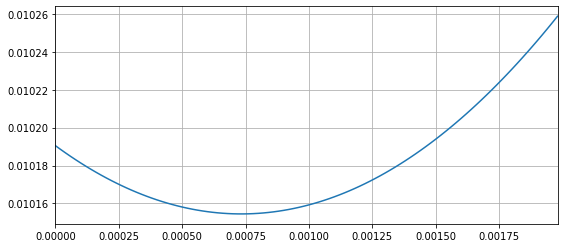

In [11]:
build_plot(X_train, y_train, X_val, y_val)

In [12]:
regr = GradientLR(0.1, iterations=10000,l=0.00075)
regr.fit(X_train, y_train)
y_pred = regr.predict(X_test)
print(f"MSE: {mse(y_test, y_pred)}, R2: {r2(y_test, y_pred)}")

MSE: 0.00971497294669727, R2: 0.996810323069006


### Задание 4 (2 балла)
Протестируйте оба метода на данных `boston.csv`, для градиентного спуска постройте график зависимости ошибки от коэффициента регуляризации. 

In [13]:
X, y = read_data()
X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.8, shuffle=False)

In [14]:
regr = NormalLR()
regr.fit(X_train, y_train)
y_pred = regr.predict(X_val)
print(f"MSE: {mse(y_val, y_pred)}, R2: {r2(y_val, y_pred)}")

MSE: 22266311.080836963, R2: 0.6872797475661041


Подберем кожффициент регуляризации. 

Модифицируем функцию build plot, чтобы она возвращала l, на котором достигается минимум MSE.

In [15]:
def build_plot_l(X_train, y_train, X_test, y_test):
    xs = np.arange(0.0, 100, 1)
    errors = []
    min_mse = np.inf
    for x in xs:
        regr = GradientLR(0.1, iterations=10000, l=x)
        regr.fit(X_train, y_train)
        cur_mse = mse(y_test, regr.predict(X_test))
        errors.append(cur_mse)
        
        if cur_mse < min_mse:
            min_mse = cur_mse
            l = x
        
    plt.figure(figsize=(9, 4))
    plt.xlim(xs[0], xs[-1])
    plt.grid()
    plt.plot(xs, errors)
    plt.show()
    
    return l

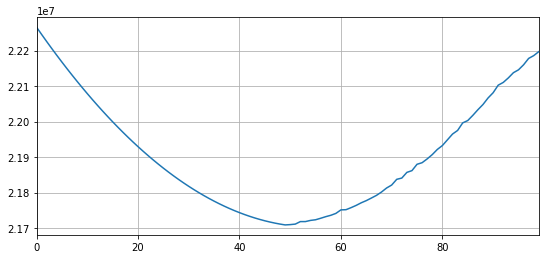

In [16]:
best_l = build_plot_l(X_train, y_train, X_val, y_val)

In [17]:
best_l

49.0

Мда уж, коэффициент регуляризации получился большим

Теперь подберем лучший learning rate (alpha).

In [18]:
def build_plot_alpha(X_train, y_train, X_test, y_test):
    xs = np.arange(0.0, 0.25, 0.01)
    errors = []
    min_mse = np.inf
    for x in xs:
        regr = GradientLR(alpha=x, iterations=10000, l=best_l)
        regr.fit(X_train, y_train)
        cur_mse = mse(y_test, regr.predict(X_test))
        errors.append(cur_mse)
        
        if cur_mse < min_mse:
            min_mse = cur_mse
            alpha = x
            
        
    plt.figure(figsize=(9, 4))
    plt.xlim(xs[0], xs[-1])
    plt.grid()
    plt.plot(xs, errors)
    plt.show()
    
    return alpha

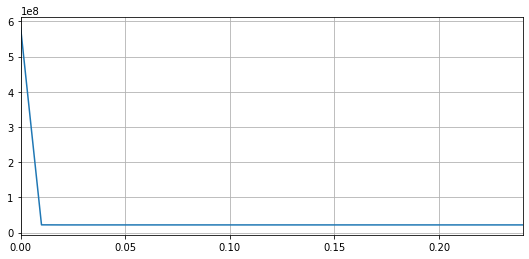

In [19]:
best_alpha = build_plot_alpha(X_train, y_train, X_val, y_val)

In [20]:
best_alpha

0.03

In [21]:
regr = GradientLR(alpha=best_alpha, iterations=10000, l=best_l)
regr.fit(X_train, y_train)
y_pred
print(f"MSE: {mse(y_val, y_pred)}, R2: {r2(y_val, y_val)}")

MSE: 22266311.080836963, R2: 1.0


### Задание 5 (2 балла)
Проинтерпритируйте полученные результаты. Опишите влияние каждого признака на результат предсказания.

Распределение весов по признакам:

In [22]:
import pandas as pd

result = pd.Series(regr.w)
result.index = ['w_0', 'crim', 'zn', 'indus', 'chas', 'nox', 'rm', 'age', 'dis', 'rad', 'tax', 'ptratio', 'b', 'lstat']

result

w_0        22497.220688
crim       -4011.714394
zn          3357.472122
indus        -45.870110
chas        2211.327679
nox        -5040.677941
rm         21744.182850
age            5.847402
dis       -11491.393167
rad         4354.332921
tax        -5171.522925
ptratio    -7435.364647
b           4027.861549
lstat     -18518.305382
dtype: float64

Итак, видим, что "базовая" цена недвижимости: 22497 долларов (имеется ввиду, когда остальные признаки минимальны, а их нормализованные значения - ноль)

Видим, что следующие признаки отрицательно влияют на цену недвижимости: криминал в районе (crim), вредные выбросы в окружающую среду (nox), дальность до основных точек работы (dis), налог на недвижимость (tax), количество людей с пониженным социальным статусом в районе (lstat). Причем lstat влияет на цены недвижимости хуже всего.

Видим, что следующие признаки положительно влияют на цену недвижимости: близость к рекам (chas), количество комнат (rm), близость до основных шоссе (rad). Причем признак rm влияет больше всего.

Также видим, что признаки indus и age практически не влияют на цену недвижимости.

В целом, получили логичные результаты.